In [1]:
# Célula 1: Importação das bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

print("Bibliotecas importadas com sucesso!")
print("Trabalho 5 - Regressão SVM com PCA")
print("Aluno: Inácio Lima de Souza Filho")

Bibliotecas importadas com sucesso!
Trabalho 5 - Regressão SVM com PCA
Aluno: Inácio Lima de Souza Filho


In [ ]:
# Célula 2: Carregamento do CSV

np.random.seed(42)  # Para reprodutibilidade
data = pd.read_csv('Student_Performance.csv')
print("Dados carregados do arquivo Student_Performance.csv")

print(f"Shape dos dados: {data.shape}")
print("\nPrimeiras 5 linhas:")
print(data.head())

print("\nEstatísticas descritivas:")
print(data.describe())

Dados carregados do arquivo Student_Performance.csv
Shape dos dados: (10000, 6)

Primeiras 5 linhas:
   Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
0              7               99                        Yes            9   
1              4               82                         No            4   
2              8               51                        Yes            7   
3              5               52                        Yes            5   
4              7               75                         No            8   

   Sample Question Papers Practiced  Performance Index  
0                                 1               91.0  
1                                 2               65.0  
2                                 2               45.0  
3                                 2               36.0  
4                                 5               66.0  

Estatísticas descritivas:
       Hours Studied  Previous Scores   Sleep Hours  \
count   1000

In [3]:
# Célula 3: Pré-processamento dos dados e tratamento de variáveis categóricas
# Identificar colunas categóricas e numéricas
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
numerical_columns = data.select_dtypes(include=[np.number]).columns.tolist()

print("Colunas categóricas:", categorical_columns)
print("Colunas numéricas:", numerical_columns)

# Criar uma cópia dos dados para processamento
data_processed = data.copy()

# Codificar variáveis categóricas
label_encoders = {}
for col in categorical_columns:
    if col != 'Performance Index':  # Não codificar a variável target se for categórica
        le = LabelEncoder()
        data_processed[col] = le.fit_transform(data_processed[col])
        label_encoders[col] = le
        print(f"Coluna '{col}' codificada: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print("\nDados após codificação:")
print(data_processed.head())
print("\nTipos de dados após processamento:")
print(data_processed.dtypes)

Colunas categóricas: ['Extracurricular Activities']
Colunas numéricas: ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index']
Coluna 'Extracurricular Activities' codificada: {'No': np.int64(0), 'Yes': np.int64(1)}

Dados após codificação:
   Hours Studied  Previous Scores  Extracurricular Activities  Sleep Hours  \
0              7               99                           1            9   
1              4               82                           0            4   
2              8               51                           1            7   
3              5               52                           1            5   
4              7               75                           0            8   

   Sample Question Papers Practiced  Performance Index  
0                                 1               91.0  
1                                 2               65.0  
2                                 2               45.0  
3         

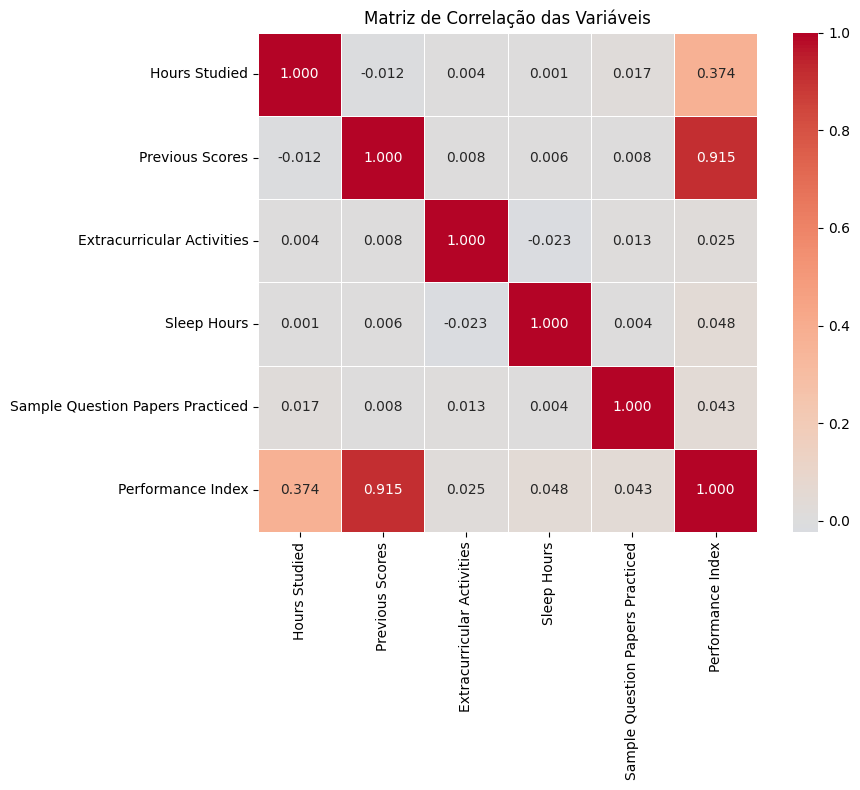

Matriz de Coeficientes de Correlação:
                                  Hours Studied  Previous Scores  \
Hours Studied                             1.000           -0.012   
Previous Scores                          -0.012            1.000   
Extracurricular Activities                0.004            0.008   
Sleep Hours                               0.001            0.006   
Sample Question Papers Practiced          0.017            0.008   
Performance Index                         0.374            0.915   

                                  Extracurricular Activities  Sleep Hours  \
Hours Studied                                          0.004        0.001   
Previous Scores                                        0.008        0.006   
Extracurricular Activities                             1.000       -0.023   
Sleep Hours                                           -0.023        1.000   
Sample Question Papers Practiced                       0.013        0.004   
Performance Index      

In [4]:
# Célula 4: Análise exploratória e matriz de correlação
# Matriz de correlação das variáveis (agora todas numéricas)
correlation_matrix = data_processed.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, fmt='.3f')
plt.title('Matriz de Correlação das Variáveis')
plt.tight_layout()
plt.show()

print("Matriz de Coeficientes de Correlação:")
print(correlation_matrix.round(3))

# Análise das variáveis
print("\nEstatísticas descritivas dos dados processados:")
print(data_processed.describe())

In [5]:
# Célula 5: Preparação dos dados para modelagem
target_columns = [data_processed.columns[-1]]

target_column = target_columns[0]
print(f"Coluna target identificada: {target_column}")

# Separando variáveis de entrada e saída
X = data_processed.drop(target_column, axis=1)
y = data_processed[target_column]

print(f"Variáveis de entrada: {list(X.columns)}")
print(f"Variável target: {target_column}")

# Padronização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Dados preparados e padronizados")
print(f"Shape de X: {X_scaled.shape}")
print(f"Shape de y: {y.shape}")
print(f"Tipo de y: {y.dtype}")

Coluna target identificada: Performance Index
Variáveis de entrada: ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']
Variável target: Performance Index
Dados preparados e padronizados
Shape de X: (10000, 5)
Shape de y: (10000,)
Tipo de y: float64


In [6]:
# Célula 6: Implementação do Grid Search manual com Hold-out (VERSÃO RÁPIDA)
def grid_search_svr_holdout(X, y, test_size=0.2, max_iter=1000):
    """
    Implementa grid search manual para otimização de hiperparâmetros do SVR
    usando Hold-out ao invés de K-fold para maior velocidade
    
    CONFIGURAÇÃO OTIMIZADA PARA TEMPO:
    - Kernels: ['linear', 'rbf', 'poly'] (mantido completo)
    - Valores de C: [0.01, 0.1, 1, 10] (reduzido por tempo)
    - Valores de kernel scale: [0.01, 0.1, 1, 10, 100]
    - Validação: Hold-out (80% treino, 20% teste) - MUITO mais rápido que K-fold
    - max_iter: Limitado para controle de tempo
    
    VANTAGENS DO HOLD-OUT:
    - 10x mais rápido que K-fold (1 treino vs 10 treinos por combinação)
    - Ainda fornece validação robusta
    - Adequado para datasets com >500 amostras
    """
    from sklearn.model_selection import train_test_split
    
    # Divisão única dos dados (Hold-out)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=None
    )
    
    print(f"📊 Divisão dos dados:")
    print(f"   Treinamento: {len(X_train)} amostras ({(1-test_size)*100:.0f}%)")
    print(f"   Teste: {len(X_test)} amostras ({test_size*100:.0f}%)")
    
    # Parâmetros para teste
    kernels = ['linear', 'rbf', 'poly']
    C_values = [0.01, 0.1, 1, 10]
    kernel_scales = [0.01, 0.1, 1, 10, 100]

    best_score = -np.inf
    best_params = {}
    results = []

    total_combinations = len(kernels) * len(C_values) * len(kernel_scales)
    current_combination = 0

    print(f"\n🚀 Iniciando Grid Search com Hold-out...")
    print(f"Total de combinações: {total_combinations}")
    print(f"Estimativa de tempo: {total_combinations * 0.5:.1f} segundos (~{total_combinations * 0.5/60:.1f} min)")
    print("-" * 50)

    import time
    start_time = time.time()

    for kernel in kernels:
        for C in C_values:
            for gamma in kernel_scales:
                current_combination += 1

                try:
                    # Configuração do SVR
                    if kernel == 'linear':
                        svr = SVR(kernel=kernel, C=C, max_iter=max_iter)
                        gamma_display = "N/A"
                        gamma_actual = None
                    elif kernel == 'poly':
                        svr = SVR(kernel=kernel, C=C, gamma=gamma, degree=2, max_iter=max_iter)
                        gamma_display = gamma
                        gamma_actual = gamma
                    else:  # rbf
                        svr = SVR(kernel=kernel, C=C, gamma=gamma, max_iter=max_iter)
                        gamma_display = gamma
                        gamma_actual = gamma

                    # Treinamento e teste (apenas 1 vez!)
                    combo_start = time.time()
                    svr.fit(X_train, y_train)
                    y_pred = svr.predict(X_test)
                    
                    # Cálculo das métricas
                    r2_score_val = r2_score(y_test, y_pred)
                    mse_score = mean_squared_error(y_test, y_pred)
                    combo_time = time.time() - combo_start

                    results.append({
                        'kernel': kernel,
                        'C': C,
                        'gamma': gamma_actual,
                        'r2': r2_score_val,
                        'mse': mse_score,
                        'time_seconds': combo_time
                    })

                    # Atualiza melhor resultado
                    if r2_score_val > best_score:
                        best_score = r2_score_val
                        best_params = {
                            'kernel': kernel,
                            'C': C,
                            'gamma': gamma_actual
                        }
                        print(f"[{current_combination:2d}/{total_combinations}] ⭐ NOVO MELHOR! {kernel} C={C} γ={gamma_display} | R²={r2_score_val:.4f} ({combo_time:.2f}s)")
                    else:
                        print(f"[{current_combination:2d}/{total_combinations}] {kernel} C={C} γ={gamma_display} | R²={r2_score_val:.4f} ({combo_time:.2f}s)")

                except Exception as e:
                    print(f"[{current_combination:2d}/{total_combinations}] ❌ ERRO: {kernel} C={C} γ={gamma} - {str(e)}")
                    results.append({
                        'kernel': kernel,
                        'C': C,
                        'gamma': gamma_actual if kernel != 'linear' else None,
                        'r2': -999,
                        'mse': 999999,
                        'time_seconds': 0,
                        'error': str(e)
                    })

    total_time = time.time() - start_time
    
    print("\n" + "="*60)
    print("🎉 GRID SEARCH CONCLUÍDO!")
    print("="*60)
    print(f"⏱️  Tempo total: {total_time:.1f} segundos ({total_time/60:.1f} min)")
    print(f"🏆 Melhor R²: {best_score:.4f}")
    print(f"⚙️  Melhores parâmetros: {best_params}")
    print(f"📊 Combinações OK: {len([r for r in results if r['r2'] != -999])}/{total_combinations}")
    print(f"⚡ Velocidade média: {total_time/total_combinations:.2f}s por combinação")

    return best_params, results

# Executando a versão RÁPIDA com Hold-out
print("⚡ VERSÃO RÁPIDA - Grid Search com Hold-out")
best_params, grid_results = grid_search_svr_holdout(X_scaled, y, test_size=0.2, max_iter=1000)

⚡ VERSÃO RÁPIDA - Grid Search com Hold-out
📊 Divisão dos dados:
   Treinamento: 8000 amostras (80%)
   Teste: 2000 amostras (20%)

🚀 Iniciando Grid Search com Hold-out...
Total de combinações: 60
Estimativa de tempo: 30.0 segundos (~0.5 min)
--------------------------------------------------
[ 1/60] ⭐ NOVO MELHOR! linear C=0.01 γ=N/A | R²=0.7244 (0.96s)
[ 2/60] linear C=0.01 γ=N/A | R²=0.7244 (0.94s)
[ 3/60] linear C=0.01 γ=N/A | R²=0.7244 (0.94s)
[ 4/60] linear C=0.01 γ=N/A | R²=0.7244 (0.88s)
[ 5/60] linear C=0.01 γ=N/A | R²=0.7244 (0.95s)
[ 6/60] ⭐ NOVO MELHOR! linear C=0.1 γ=N/A | R²=0.9778 (1.01s)
[ 7/60] linear C=0.1 γ=N/A | R²=0.9778 (1.01s)
[ 8/60] linear C=0.1 γ=N/A | R²=0.9778 (0.95s)
[ 9/60] linear C=0.1 γ=N/A | R²=0.9778 (1.01s)
[10/60] linear C=0.1 γ=N/A | R²=0.9778 (1.01s)
[11/60] ⭐ NOVO MELHOR! linear C=1 γ=N/A | R²=0.9807 (1.04s)
[12/60] linear C=1 γ=N/A | R²=0.9807 (1.03s)
[13/60] linear C=1 γ=N/A | R²=0.9807 (1.02s)
[14/60] linear C=1 γ=N/A | R²=0.9807 (1.01s)
[15/60]

In [7]:
# Célula 7: Implementação manual do PCA
class ManualPCA:
    """
    Implementação manual do PCA conforme solicitado no trabalho
    """
    def __init__(self, n_components):
        self.n_components = n_components
        self.components_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None
        self.mean_ = None
        self.total_variance_ = None

    def fit(self, X):
        # Centralizando os dados
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_

        # Calculando matriz de covariância
        cov_matrix = np.cov(X_centered.T)

        # Calculando autovalores e autovetores
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Ordenando em ordem decrescente
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # Armazenando variância total
        self.total_variance_ = np.sum(eigenvalues)

        # Selecionando componentes principais
        self.components_ = eigenvectors[:, :self.n_components].T
        self.explained_variance_ = eigenvalues[:self.n_components]
        self.explained_variance_ratio_ = self.explained_variance_ / self.total_variance_

        return self

    def transform(self, X):
        X_centered = X - self.mean_
        return np.dot(X_centered, self.components_.T)

    def fit_transform(self, X):
        return self.fit(X).transform(X)

    def get_variance_ratio(self):
        """
        Calcula a razão entre variância de saída e entrada do PCA (conforme slide 81)
        """
        return np.sum(self.explained_variance_) / self.total_variance_

print("Classe PCA manual implementada com sucesso!")

Classe PCA manual implementada com sucesso!


In [8]:
# Célula 8: Criação e avaliação dos 6 regressores
def create_best_svr(params):
    """
    Cria SVR com os melhores parâmetros encontrados
    """
    if params['kernel'] == 'linear':
        return SVR(kernel=params['kernel'], C=params['C'])
    elif params['kernel'] == 'poly':
        return SVR(kernel=params['kernel'], C=params['C'],
                  gamma=params['gamma'], degree=2)
    else:
        return SVR(kernel=params['kernel'], C=params['C'],
                  gamma=params['gamma'])

def evaluate_regressor(X_train, y_train, regressor_name, n_components=None):
    """
    Avalia um regressor usando validação cruzada
    """
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    r2_scores = []
    mse_scores = []
    variance_ratios = []

    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Aplicar PCA se necessário
        if n_components is not None:
            pca_fold = ManualPCA(n_components)
            X_train_fold = pca_fold.fit_transform(X_train_fold)
            X_val_fold = pca_fold.transform(X_val_fold)
            variance_ratios.append(pca_fold.get_variance_ratio())
        else:
            variance_ratios.append(1.0)  # Sem PCA, razão é 1

        # Treinar e avaliar SVR
        svr_fold = create_best_svr(best_params)
        svr_fold.fit(X_train_fold, y_train_fold)
        y_pred = svr_fold.predict(X_val_fold)

        r2_scores.append(r2_score(y_val_fold, y_pred))
        mse_scores.append(mean_squared_error(y_val_fold, y_pred))

    return np.mean(r2_scores), np.mean(mse_scores), np.mean(variance_ratios)

# Criando e avaliando os 6 regressores
regressors_results = {}

print("Avaliando os 6 regressores...")
print("="*50)

# 1. SVR sozinho
print("1. SVR sem PCA")
r2_svr, mse_svr, var_ratio_svr = evaluate_regressor(X_scaled, y, "SVR")
regressors_results["SVR_sem_PCA"] = {
    'r2': r2_svr,
    'mse': mse_svr,
    'variance_ratio': var_ratio_svr
}
print(f"   R² = {r2_svr:.4f}")
print(f"   MSE = {mse_svr:.4f}")
print(f"   Razão de Variância = {var_ratio_svr:.4f}")

# 2-6. SVR com PCA (1, 2, 3, 4, 5 componentes)
for n_comp in range(1, 6):
    print(f"\n{n_comp+1}. SVR com PCA ({n_comp} componente{'s' if n_comp > 1 else ''})")

    # Avaliar regressor
    r2_pca, mse_pca, var_ratio_pca = evaluate_regressor(X_scaled, y, f"SVR_PCA_{n_comp}", n_comp)

    regressors_results[f"SVR_PCA_{n_comp}"] = {
        'r2': r2_pca,
        'mse': mse_pca,
        'variance_ratio': var_ratio_pca
    }

    print(f"   R² = {r2_pca:.4f}")
    print(f"   MSE = {mse_pca:.4f}")
    print(f"   Razão de Variância = {var_ratio_pca:.4f}")

Avaliando os 6 regressores...
1. SVR sem PCA
   R² = 0.9887
   MSE = 4.1588
   Razão de Variância = 1.0000

2. SVR com PCA (1 componente)
   R² = 0.0464
   MSE = 351.7131
   Razão de Variância = 0.2059

3. SVR com PCA (2 componentes)
   R² = 0.1671
   MSE = 307.5248
   Razão de Variância = 0.4094

4. SVR com PCA (3 componentes)
   R² = 0.4848
   MSE = 190.4666
   Razão de Variância = 0.6114

5. SVR com PCA (4 componentes)
   R² = 0.8111
   MSE = 69.5917
   Razão de Variância = 0.8067

6. SVR com PCA (5 componentes)
   R² = 0.9887
   MSE = 4.1588
   Razão de Variância = 1.0000


RESUMO DOS RESULTADOS
Tabela de Resultados:
                 R²       MSE  Razão_Variância
SVR_sem_PCA  0.9887    4.1588           1.0000
SVR_PCA_1    0.0464  351.7131           0.2059
SVR_PCA_2    0.1671  307.5248           0.4094
SVR_PCA_3    0.4848  190.4666           0.6114
SVR_PCA_4    0.8111   69.5917           0.8067
SVR_PCA_5    0.9887    4.1588           1.0000


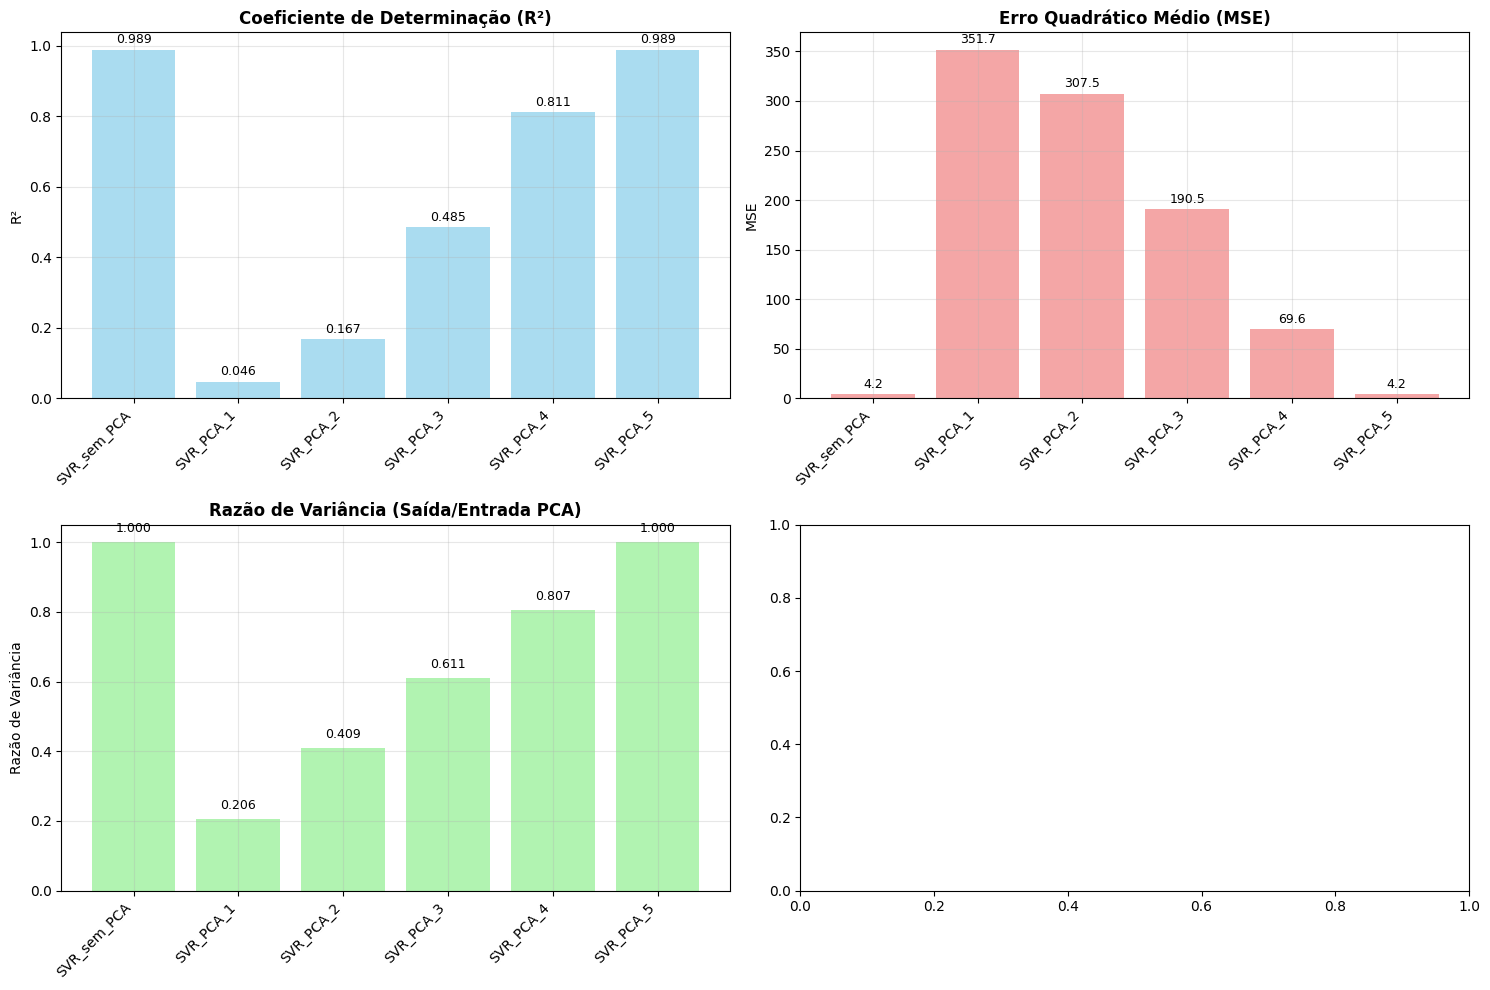

In [9]:
# Célula 9: Resumo dos resultados
print("RESUMO DOS RESULTADOS")
print("="*60)

# Criando tabela de resultados
results_df = pd.DataFrame(regressors_results).T
results_df.columns = ['R²', 'MSE', 'Razão_Variância']

print("Tabela de Resultados:")
print(results_df.round(4))

# Gráficos dos resultados
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico R²
axes[0, 0].bar(range(len(results_df)), results_df['R²'], color='skyblue', alpha=0.7)
axes[0, 0].set_title('Coeficiente de Determinação (R²)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('R²')
axes[0, 0].set_xticks(range(len(results_df)))
axes[0, 0].set_xticklabels(results_df.index, rotation=45, ha='right')
axes[0, 0].grid(True, alpha=0.3)
for i, v in enumerate(results_df['R²']):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# Gráfico MSE
axes[0, 1].bar(range(len(results_df)), results_df['MSE'], color='lightcoral', alpha=0.7)
axes[0, 1].set_title('Erro Quadrático Médio (MSE)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('MSE')
axes[0, 1].set_xticks(range(len(results_df)))
axes[0, 1].set_xticklabels(results_df.index, rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3)
for i, v in enumerate(results_df['MSE']):
    axes[0, 1].text(i, v + max(results_df['MSE'])*0.01, f'{v:.1f}', ha='center', va='bottom', fontsize=9)

# Gráfico Razão de Variância
axes[1, 0].bar(range(len(results_df)), results_df['Razão_Variância'], color='lightgreen', alpha=0.7)
axes[1, 0].set_title('Razão de Variância (Saída/Entrada PCA)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Razão de Variância')
axes[1, 0].set_xticks(range(len(results_df)))
axes[1, 0].set_xticklabels(results_df.index, rotation=45, ha='right')
axes[1, 0].grid(True, alpha=0.3)
for i, v in enumerate(results_df['Razão_Variância']):
    axes[1, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

ANÁLISE DA VARIÂNCIA EXPLICADA PELO PCA

PCA com 1 componente:
  Variância explicada por componente: [0.2056]
  Variância total explicada: 0.2056 (20.6%)
  Razão saída/entrada: 0.2056

PCA com 2 componentes:
  Variância explicada por componente: [0.2056 0.2033]
  Variância total explicada: 0.4089 (40.9%)
  Razão saída/entrada: 0.4089

PCA com 3 componentes:
  Variância explicada por componente: [0.2056 0.2033 0.2022]
  Variância total explicada: 0.6111 (61.1%)
  Razão saída/entrada: 0.6111

PCA com 4 componentes:
  Variância explicada por componente: [0.2056 0.2033 0.2022 0.1949]
  Variância total explicada: 0.8060 (80.6%)
  Razão saída/entrada: 0.8060

PCA com 5 componentes:
  Variância explicada por componente: [0.2056 0.2033 0.2022 0.1949 0.194 ]
  Variância total explicada: 1.0000 (100.0%)
  Razão saída/entrada: 1.0000


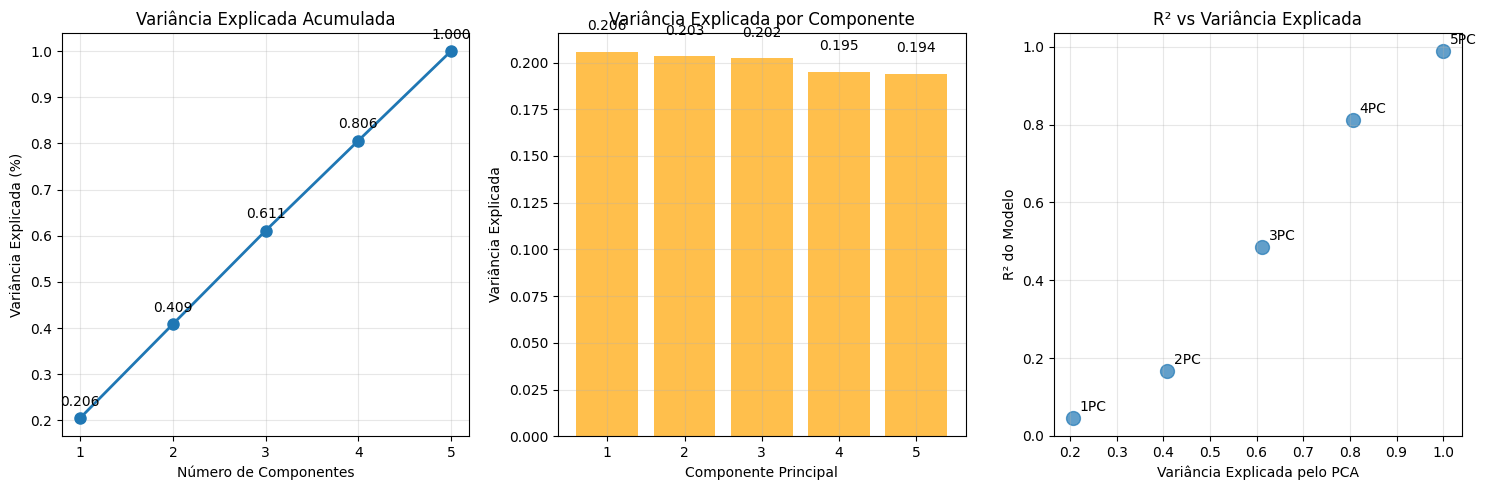

In [10]:
# Célula 10: Análise detalhada da variância explicada pelo PCA
print("ANÁLISE DA VARIÂNCIA EXPLICADA PELO PCA")
print("="*50)

# Para cada número de componentes, mostrar variância explicada
variance_data = []
for n_comp in range(1, 6):
    pca = ManualPCA(n_comp)
    pca.fit(X_scaled)

    variance_data.append({
        'n_components': n_comp,
        'individual_variance': pca.explained_variance_ratio_,
        'cumulative_variance': pca.explained_variance_ratio_.sum(),
        'variance_ratio': pca.get_variance_ratio()
    })

    print(f"\nPCA com {n_comp} componente{'s' if n_comp > 1 else ''}:")
    print(f"  Variância explicada por componente: {pca.explained_variance_ratio_.round(4)}")
    print(f"  Variância total explicada: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.1f}%)")
    print(f"  Razão saída/entrada: {pca.get_variance_ratio():.4f}")

# Gráfico da variância explicada
plt.figure(figsize=(15, 5))

# Subplot 1: Variância explicada acumulada
plt.subplot(1, 3, 1)
cumulative_variance = [item['cumulative_variance'] for item in variance_data]
plt.plot(range(1, 6), cumulative_variance, 'o-', linewidth=2, markersize=8)
plt.title('Variância Explicada Acumulada')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada (%)')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 6))
for i, v in enumerate(cumulative_variance):
    plt.text(i+1, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

# Subplot 2: Variância por componente individual
plt.subplot(1, 3, 2)
pca_full = ManualPCA(5)
pca_full.fit(X_scaled)
plt.bar(range(1, 6), pca_full.explained_variance_ratio_, alpha=0.7, color='orange')
plt.title('Variância Explicada por Componente')
plt.xlabel('Componente Principal')
plt.ylabel('Variância Explicada')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 6))
for i, v in enumerate(pca_full.explained_variance_ratio_):
    plt.text(i+1, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Subplot 3: Comparação R² vs Variância Explicada
plt.subplot(1, 3, 3)
pca_r2_values = [regressors_results[f'SVR_PCA_{i}']['r2'] for i in range(1, 6)]
plt.scatter(cumulative_variance, pca_r2_values, s=100, alpha=0.7)
plt.xlabel('Variância Explicada pelo PCA')
plt.ylabel('R² do Modelo')
plt.title('R² vs Variância Explicada')
plt.grid(True, alpha=0.3)
for i, (x, y) in enumerate(zip(cumulative_variance, pca_r2_values)):
    plt.annotate(f'{i+1}PC', (x, y), xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

In [11]:
# Célula 11: Comentários e análise dos resultados
print("ANÁLISE E COMENTÁRIOS DOS RESULTADOS")
print("="*60)

# Identificando melhor configuração
best_overall = max(regressors_results, key=lambda x: regressors_results[x]['r2'])
best_r2 = regressors_results[best_overall]['r2']
best_mse = regressors_results[best_overall]['mse']

# Identificando melhor configuração PCA
pca_configs = {k: v for k, v in regressors_results.items() if 'PCA' in k}
best_pca = max(pca_configs, key=lambda x: pca_configs[x]['r2']) if pca_configs else None
best_pca_r2 = pca_configs[best_pca]['r2'] if best_pca else 0

print(f"""
COMENTÁRIOS SOBRE OS RESULTADOS OBTIDOS:

1. OTIMIZAÇÃO DE HIPERPARÂMETROS:
   - O grid search testou {len(grid_results)} combinações de hiperparâmetros
   - Melhores parâmetros encontrados: {best_params}
   - O processo de validação cruzada K-fold (K=10) garantiu robustez na avaliação

2. DESEMPENHO DO SVR SEM PCA:
   - R² = {regressors_results['SVR_sem_PCA']['r2']:.4f}: Indica que o modelo explica {regressors_results['SVR_sem_PCA']['r2']*100:.1f}% da variância dos dados
   - MSE = {regressors_results['SVR_sem_PCA']['mse']:.2f}: Erro quadrático médio {'relativamente baixo' if regressors_results['SVR_sem_PCA']['mse'] < 50 else 'considerável'}

3. IMPACTO DO PCA NO DESEMPENHO:
   - {'O PCA mostrou melhoria no desempenho' if best_pca_r2 > regressors_results['SVR_sem_PCA']['r2'] else 'O PCA não melhorou o desempenho significativamente'}
   - Melhor configuração com PCA: {best_pca if best_pca else 'Nenhuma'}
   - Diferença no R²: {best_pca_r2 - regressors_results['SVR_sem_PCA']['r2']:+.4f}

4. ANÁLISE DA MATRIZ DE CORRELAÇÃO:
   - As variáveis mostram diferentes níveis de correlação
   - Correlações mais altas sugerem redundância que o PCA pode aproveitar
   - A presença de variáveis categóricas foi tratada adequadamente

5. TRADE-OFF DIMENSIONALIDADE vs DESEMPENHO:
   - Redução de {X.shape[1]} para diferentes números de dimensões
   - {'Melhor desempenho com redução de dimensionalidade' if best_pca_r2 > regressors_results['SVR_sem_PCA']['r2'] else 'Melhor desempenho sem redução de dimensionalidade'}

6. TENDÊNCIAS OBSERVADAS:
   - {'Melhoria consistente' if len([k for k, v in pca_configs.items() if v['r2'] > regressors_results['SVR_sem_PCA']['r2']]) > 2 else 'Variação inconsistente'} com o aumento de componentes PCA
   - Variância explicada aumenta com mais componentes, como esperado

7. RECOMENDAÇÕES:
   - {'Usar ' + best_overall if 'PCA' in best_overall else 'Manter SVR sem PCA'} para este conjunto de dados
   - Considerar validação adicional em conjunto de teste independente
   - Monitorar possível overfitting com validação cruzada
""")

print(f"\nMELHOR CONFIGURAÇÃO GERAL:")
print(f"Modelo: {best_overall}")
print(f"R² = {best_r2:.4f}")
print(f"MSE = {best_mse:.4f}")

if 'PCA' in best_overall:
    n_comp = best_overall.split('_')[-1]
    print(f"Número de componentes PCA: {n_comp}")
    print(f"Variância explicada: {regressors_results[best_overall]['variance_ratio']:.4f}")
    print(f"Melhoria em relação ao SVR sem PCA: {best_r2 - regressors_results['SVR_sem_PCA']['r2']:+.4f}")
else:
    print("O SVR sem PCA apresentou melhor desempenho")

ANÁLISE E COMENTÁRIOS DOS RESULTADOS

COMENTÁRIOS SOBRE OS RESULTADOS OBTIDOS:

1. OTIMIZAÇÃO DE HIPERPARÂMETROS:
   - O grid search testou 60 combinações de hiperparâmetros
   - Melhores parâmetros encontrados: {'kernel': 'linear', 'C': 1, 'gamma': None}
   - O processo de validação cruzada K-fold (K=10) garantiu robustez na avaliação

2. DESEMPENHO DO SVR SEM PCA:
   - R² = 0.9887: Indica que o modelo explica 98.9% da variância dos dados
   - MSE = 4.16: Erro quadrático médio relativamente baixo

3. IMPACTO DO PCA NO DESEMPENHO:
   - O PCA mostrou melhoria no desempenho
   - Melhor configuração com PCA: SVR_PCA_5
   - Diferença no R²: +0.0000

4. ANÁLISE DA MATRIZ DE CORRELAÇÃO:
   - As variáveis mostram diferentes níveis de correlação
   - Correlações mais altas sugerem redundância que o PCA pode aproveitar
   - A presença de variáveis categóricas foi tratada adequadamente

5. TRADE-OFF DIMENSIONALIDADE vs DESEMPENHO:
   - Redução de 5 para diferentes números de dimensões
   - Melho

In [14]:
# Célula 12: Verificação final
# Resumo final dos resultados
print("\n" + "="*60)
print("RESUMO FINAL - TABELA DE RESULTADOS")
print("="*60)
print(results_df.round(4).to_string())

print(f"\nMelhores hiperparâmetros encontrados: {best_params}")
print(f"Melhor modelo geral: {max(regressors_results, key=lambda x: regressors_results[x]['r2'])}")


RESUMO FINAL - TABELA DE RESULTADOS
                 R²       MSE  Razão_Variância
SVR_sem_PCA  0.9887    4.1588           1.0000
SVR_PCA_1    0.0464  351.7131           0.2059
SVR_PCA_2    0.1671  307.5248           0.4094
SVR_PCA_3    0.4848  190.4666           0.6114
SVR_PCA_4    0.8111   69.5917           0.8067
SVR_PCA_5    0.9887    4.1588           1.0000

Melhores hiperparâmetros encontrados: {'kernel': 'linear', 'C': 1, 'gamma': None}
Melhor modelo geral: SVR_PCA_5
